# Topic Modelling with LSA and LDA

- In this kernel, two topic modelling algorithms are explored: LSA and LDA.

## Exploratory Data Analysis

In [81]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

from gensim.models import LdaModel
from gensim.corpora import Dictionary

%matplotlib inline

Loading BokehJS ...

## Data Cleaning

In [82]:
# Read in data
# df = pd.read_excel('excel_file.xlsx')
# print(df.shape)
# df = pd.read_excel('excel_file.xlsx', encoding='utf-8')
# print(df.shape)
df = pd.read_excel('excel_file.xlsx')
print(df.shape)


(3848, 7)


In [83]:
df.head(10)

,name,price,reviewers,dates,ratings,titles,contents
0,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Abraham,"Reviewed in the United States on June 4, 2023",4.6 out of 5,Worth every penny,This is a must have if you are in a rainy area...
1,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,The Review,"Reviewed in the United States on April 23, 2023",4.6 out of 5,comfortable and completely water proof,"very wet rainy season this year, so had ample ..."
2,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Abraham,"Reviewed in the United States on June 4, 2023",4.6 out of 5,Muy útil,"Cómoda , resiste el frío y el agua"
3,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Amazon Customer,"Reviewed in the United States on May 17, 2023",4.6 out of 5,Very Nice,Fits well and great materials and construction
4,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Nelson Junior Jara Montiel,"Reviewed in the United States on May 28, 2023",4.6 out of 5,"Different fit, cheaper design",I am replacing the original venture jacket. Th...
5,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,JRandyMyrick,"Reviewed in the United States on May 1, 2023",4.6 out of 5,Garment,Color inside. Pockets
6,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,The Review,"Reviewed in the United States on April 23, 2023",4.6 out of 5,Keeps me dry.,The jacket looks to be well made and did a gre...
7,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,harv,"Reviewed in the United States on June 3, 2023",4.6 out of 5,Outstanding Quality,Exactly what I ordered! The product is outstan...
8,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Sam,"Reviewed in the United States on February 27, ...",4.6 out of 5,as expected,very lightweight weatherproof shell. the mater...
9,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85 -\n$109.95,Amy,"Reviewed in the United States on March 18, 2023",4.6 out of 5,It's just a basic windbreaker,You're definitly only paying for the name. The...


In [84]:
df['contents'].values[1000]

'Beautiful north face jacket perfect for the rain.'

In [85]:
# Assuming the DataFrame is named 'df' and the column is named 'price'
# df['price'] = df['price'].str.replace(r'\.\d+', '', regex=True)

# Assuming the DataFrame is named 'df' and the column is named 'price_range'
df['price'] = df['price'].str.replace(r'\s*-\s*\$[\d.]+$', '', regex=True)

In [86]:
df.head(10)

,name,price,reviewers,dates,ratings,titles,contents
0,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,Abraham,"Reviewed in the United States on June 4, 2023",4.6 out of 5,Worth every penny,This is a must have if you are in a rainy area...
1,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,The Review,"Reviewed in the United States on April 23, 2023",4.6 out of 5,comfortable and completely water proof,"very wet rainy season this year, so had ample ..."
2,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,Abraham,"Reviewed in the United States on June 4, 2023",4.6 out of 5,Muy útil,"Cómoda , resiste el frío y el agua"
3,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,Amazon Customer,"Reviewed in the United States on May 17, 2023",4.6 out of 5,Very Nice,Fits well and great materials and construction
4,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,Nelson Junior Jara Montiel,"Reviewed in the United States on May 28, 2023",4.6 out of 5,"Different fit, cheaper design",I am replacing the original venture jacket. Th...
5,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,JRandyMyrick,"Reviewed in the United States on May 1, 2023",4.6 out of 5,Garment,Color inside. Pockets
6,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,The Review,"Reviewed in the United States on April 23, 2023",4.6 out of 5,Keeps me dry.,The jacket looks to be well made and did a gre...
7,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,harv,"Reviewed in the United States on June 3, 2023",4.6 out of 5,Outstanding Quality,Exactly what I ordered! The product is outstan...
8,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,Sam,"Reviewed in the United States on February 27, ...",4.6 out of 5,as expected,very lightweight weatherproof shell. the mater...
9,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,Amy,"Reviewed in the United States on March 18, 2023",4.6 out of 5,It's just a basic windbreaker,You're definitly only paying for the name. The...


In [87]:
# Change the name of the column from "price" to "price($)"
df = df.rename(columns={'price': 'price($)'})
df.head(10)

,name,price($),reviewers,dates,ratings,titles,contents
0,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,Abraham,"Reviewed in the United States on June 4, 2023",4.6 out of 5,Worth every penny,This is a must have if you are in a rainy area...
1,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,The Review,"Reviewed in the United States on April 23, 2023",4.6 out of 5,comfortable and completely water proof,"very wet rainy season this year, so had ample ..."
2,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,Abraham,"Reviewed in the United States on June 4, 2023",4.6 out of 5,Muy útil,"Cómoda , resiste el frío y el agua"
3,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,Amazon Customer,"Reviewed in the United States on May 17, 2023",4.6 out of 5,Very Nice,Fits well and great materials and construction
4,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,Nelson Junior Jara Montiel,"Reviewed in the United States on May 28, 2023",4.6 out of 5,"Different fit, cheaper design",I am replacing the original venture jacket. Th...
5,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,JRandyMyrick,"Reviewed in the United States on May 1, 2023",4.6 out of 5,Garment,Color inside. Pockets
6,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,The Review,"Reviewed in the United States on April 23, 2023",4.6 out of 5,Keeps me dry.,The jacket looks to be well made and did a gre...
7,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,harv,"Reviewed in the United States on June 3, 2023",4.6 out of 5,Outstanding Quality,Exactly what I ordered! The product is outstan...
8,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,Sam,"Reviewed in the United States on February 27, ...",4.6 out of 5,as expected,very lightweight weatherproof shell. the mater...
9,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,$109.85,Amy,"Reviewed in the United States on March 18, 2023",4.6 out of 5,It's just a basic windbreaker,You're definitly only paying for the name. The...


In [88]:
# Remove "$" symbol from "price" column
df['price($)'] = df['price($)'].str.replace('$', '')
df.head(10)

C:\Users\peini\AppData\Local\Temp\ipykernel_22904\477465774.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price($)'] = df['price($)'].str.replace('$', '')


,name,price($),reviewers,dates,ratings,titles,contents
0,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Abraham,"Reviewed in the United States on June 4, 2023",4.6 out of 5,Worth every penny,This is a must have if you are in a rainy area...
1,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,The Review,"Reviewed in the United States on April 23, 2023",4.6 out of 5,comfortable and completely water proof,"very wet rainy season this year, so had ample ..."
2,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Abraham,"Reviewed in the United States on June 4, 2023",4.6 out of 5,Muy útil,"Cómoda , resiste el frío y el agua"
3,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Amazon Customer,"Reviewed in the United States on May 17, 2023",4.6 out of 5,Very Nice,Fits well and great materials and construction
4,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Nelson Junior Jara Montiel,"Reviewed in the United States on May 28, 2023",4.6 out of 5,"Different fit, cheaper design",I am replacing the original venture jacket. Th...
5,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,JRandyMyrick,"Reviewed in the United States on May 1, 2023",4.6 out of 5,Garment,Color inside. Pockets
6,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,The Review,"Reviewed in the United States on April 23, 2023",4.6 out of 5,Keeps me dry.,The jacket looks to be well made and did a gre...
7,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,harv,"Reviewed in the United States on June 3, 2023",4.6 out of 5,Outstanding Quality,Exactly what I ordered! The product is outstan...
8,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Sam,"Reviewed in the United States on February 27, ...",4.6 out of 5,as expected,very lightweight weatherproof shell. the mater...
9,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Amy,"Reviewed in the United States on March 18, 2023",4.6 out of 5,It's just a basic windbreaker,You're definitly only paying for the name. The...


## Data Cleaning

In [89]:
import pandas as pd
import numpy as np

def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_dataframe(df, head=5, tail=5):
    print('SHAPE'.center(82, '~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print('TYPES'.center(82, '~'))
    print(df.dtypes)
    print("~" * 82)
    print(missing_values_analysis(df))
    print('DUPLICATED VALUES'.center(83, '~'))
    print(df.duplicated().sum())
    print("QUANTILES".center(82, '~'))

    # Convert relevant columns to numeric data types
#     numeric_cols = ['price', 'reviewers', 'ratings']
    numeric_cols = ['price($)','ratings']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Calculate quantiles for numeric columns only
    numeric_df = df.select_dtypes(include=[np.number])
    if not numeric_df.empty:
        print(numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_dataframe(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 3848
Columns: 7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
name         object
price($)     object
reviewers    object
dates        object
ratings      object
titles       object
contents     object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
           Missing Values  Ratio
ratings                39   1.01
dates                  57   1.48
titles                 62   1.61
name                   75   1.95
contents               80   2.08
reviewers             207   5.38
price($)             1448  37.63
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
90
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
           0.00   0.05   0.50    0.95    0.99    1.00
price($)  27.95  29.95  88.24  128.95  199.95  199.95
ratings    3.00   3.00   4.70    

In [90]:
# Replace missing values with "anonymous" in the entire dataframe
df_filled = df.fillna("anonymous")

# Replace missing values with "anonymous" in a specific column
df['reviewers'] = df['reviewers'].fillna("anonymous")

In [91]:
def remove_repeated_words(dates):
    if isinstance(dates, float):
        return dates
    words = str(dates).split()
    unique_words = []
    for word in words:
        if word != 'Reviewed' and word != 'in' and word != 'the' and word != 'United' and word != 'States' and word != 'on' and word != 'Germany' and word != 'Canada' and word != 'France' and word != 'Italy' and  word != 'Australia' and word != 'Kingdom' and word != 'Japan' and word != 'Singapore' and word != 'Spain' and word != 'Mexico' and word != 'India' and word != 'Brazil' :
            unique_words.append(word)
    return ' '.join(unique_words)

In [92]:
df['dates'] = df['dates'].apply(remove_repeated_words)
df['dates']

0         June 4, 2023
1       April 23, 2023
2         June 4, 2023
3         May 17, 2023
4         May 28, 2023
             ...      
3843               NaN
3844               NaN
3845               NaN
3846      May 25, 2023
3847      May 25, 2023
Name: dates, Length: 3848, dtype: object

In [93]:
# Convert 'Date' column to datetime type
df['dates'] = pd.to_datetime(df['dates'])

# Fill missing values with a specific date
df['dates'] = df['dates'].fillna(method='ffill')

In [94]:
def remove_repeated_words(ratings):
    if isinstance(ratings, float):
        return ratings
    words = str(ratings).split()
    unique_words = []
    for word in words:
        if word != 'out' and word != 'of' and word != '5' :
            unique_words.append(word)
    return ' '.join(unique_words)

In [95]:
df['ratings'] = df['ratings'].apply(remove_repeated_words)
df['ratings']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
3843    5.0
3844    5.0
3845    NaN
3846    5.0
3847    5.0
Name: ratings, Length: 3848, dtype: float64

In [96]:
# Clean the 'ratings' column
df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')
# Convert the 'ratings' column to float
df['ratings'] = df['ratings'].astype(float)

In [97]:
# Calculate the mean rating
mean_rating = df['ratings'].mean()

# Fill missing values with the mean rating
df['ratings'] = df['ratings'].fillna(mean_rating)

In [98]:
df['price($)']

0       109.85
1       109.85
2       109.85
3       109.85
4       109.85
         ...  
3843     29.95
3844     29.95
3845     34.95
3846     34.95
3847     34.95
Name: price($), Length: 3848, dtype: float64

In [99]:
df_filled = df.fillna("price($)")

df['price($)'] = df['price($)'].fillna(method='bfill')

In [100]:
df_filled = df.fillna("name")

df['name'] = df['name'].fillna(method='ffill')

In [101]:
df = df.dropna()

In [102]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_dataframe(df, head=5, tail=5):
    print('SHAPE'.center(82, '~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print('TYPES'.center(82, '~'))
    print(df.dtypes)
    print("~" * 82)
    print(missing_values_analysis(df))
    print('DUPLICATED VALUES'.center(83, '~'))
    print(df.duplicated().sum())
    print("QUANTILES".center(82, '~'))

    # Convert relevant columns to numeric data types
#     numeric_cols = ['price', 'reviewers', 'ratings']
    numeric_cols = ['price($)','ratings']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Calculate quantiles for numeric columns only
    numeric_df = df.select_dtypes(include=[np.number])
    if not numeric_df.empty:
        print(numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_dataframe(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 3765
Columns: 7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
name                 object
price($)            float64
reviewers            object
dates        datetime64[ns]
ratings             float64
titles               object
contents             object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Empty DataFrame
Columns: [Missing Values, Ratio]
Index: []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
81
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
           0.00   0.05   0.50    0.95    0.99    1.00
price($)  27.95  29.95  98.95  128.95  179.95  199.95
ratings    4.58   4.58   4.58    4.58    4.58    5.00


In [103]:
df_no_duplicates = df.drop_duplicates()

In [104]:
df.drop_duplicates(inplace=True)

In [105]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_dataframe(df, head=5, tail=5):
    print('SHAPE'.center(82, '~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print('TYPES'.center(82, '~'))
    print(df.dtypes)
    print("~" * 82)
    print(missing_values_analysis(df))
    print('DUPLICATED VALUES'.center(83, '~'))
    print(df.duplicated().sum())
    print("QUANTILES".center(82, '~'))

    # Convert relevant columns to numeric data types
#     numeric_cols = ['price', 'reviewers', 'ratings']
    numeric_cols = ['price($)','ratings']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Calculate quantiles for numeric columns only
    numeric_df = df.select_dtypes(include=[np.number])
    if not numeric_df.empty:
        print(numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_dataframe(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 3684
Columns: 7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
name                 object
price($)            float64
reviewers            object
dates        datetime64[ns]
ratings             float64
titles               object
contents             object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Empty DataFrame
Columns: [Missing Values, Ratio]
Index: []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
           0.00   0.05   0.50    0.95    0.99    1.00
price($)  27.95  29.95  98.95  128.95  179.95  199.95
ratings    4.58   4.58   4.58    4.58    4.58    5.00


In [106]:
def check_class(dataframe):
    nunique_df = pd.DataFrame({'Variable': dataframe.columns,
                              'Classes': [dataframe[i].nunique() \
                                           for i in dataframe.columns]})
    nunique_df = nunique_df.sort_values('Classes', ascending = False)
    nunique_df = nunique_df.reset_index(drop = True)
    return nunique_df

check_class(df)

,Variable,Classes
0,contents,2526
1,reviewers,2234
2,titles,1702
3,dates,1324
4,name,61
5,price($),36
6,ratings,2


In [107]:
df.head(10)

,name,price($),reviewers,dates,ratings,titles,contents
0,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Abraham,2023-06-04,4.58,Worth every penny,This is a must have if you are in a rainy area...
1,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,The Review,2023-04-23,4.58,comfortable and completely water proof,"very wet rainy season this year, so had ample ..."
2,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Abraham,2023-06-04,4.58,Muy útil,"Cómoda , resiste el frío y el agua"
3,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Amazon Customer,2023-05-17,4.58,Very Nice,Fits well and great materials and construction
4,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Nelson Junior Jara Montiel,2023-05-28,4.58,"Different fit, cheaper design",I am replacing the original venture jacket. Th...
5,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,JRandyMyrick,2023-05-01,4.58,Garment,Color inside. Pockets
6,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,The Review,2023-04-23,4.58,Keeps me dry.,The jacket looks to be well made and did a gre...
7,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,harv,2023-06-03,4.58,Outstanding Quality,Exactly what I ordered! The product is outstan...
8,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Sam,2023-02-27,4.58,as expected,very lightweight weatherproof shell. the mater...
9,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Amy,2023-03-18,4.58,It's just a basic windbreaker,You're definitly only paying for the name. The...


In [108]:
df = df.reset_index()

In [109]:
df.head(10)

,index,name,price($),reviewers,dates,ratings,titles,contents
0,0,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Abraham,2023-06-04,4.58,Worth every penny,This is a must have if you are in a rainy area...
1,1,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,The Review,2023-04-23,4.58,comfortable and completely water proof,"very wet rainy season this year, so had ample ..."
2,2,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Abraham,2023-06-04,4.58,Muy útil,"Cómoda , resiste el frío y el agua"
3,3,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Amazon Customer,2023-05-17,4.58,Very Nice,Fits well and great materials and construction
4,4,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Nelson Junior Jara Montiel,2023-05-28,4.58,"Different fit, cheaper design",I am replacing the original venture jacket. Th...
5,5,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,JRandyMyrick,2023-05-01,4.58,Garment,Color inside. Pockets
6,6,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,The Review,2023-04-23,4.58,Keeps me dry.,The jacket looks to be well made and did a gre...
7,7,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,harv,2023-06-03,4.58,Outstanding Quality,Exactly what I ordered! The product is outstan...
8,8,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Sam,2023-02-27,4.58,as expected,very lightweight weatherproof shell. the mater...
9,9,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Amy,2023-03-18,4.58,It's just a basic windbreaker,You're definitly only paying for the name. The...


In [110]:
# datafile = '../input/abcnews-date-text.csv'
# raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)
# data = pd.read_excel('excel_file.xlsx')

reindexed_df = df['contents']
reindexed_df.index = df['dates']

df.head(10)

,index,name,price($),reviewers,dates,ratings,titles,contents
0,0,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Abraham,2023-06-04,4.58,Worth every penny,This is a must have if you are in a rainy area...
1,1,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,The Review,2023-04-23,4.58,comfortable and completely water proof,"very wet rainy season this year, so had ample ..."
2,2,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Abraham,2023-06-04,4.58,Muy útil,"Cómoda , resiste el frío y el agua"
3,3,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Amazon Customer,2023-05-17,4.58,Very Nice,Fits well and great materials and construction
4,4,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Nelson Junior Jara Montiel,2023-05-28,4.58,"Different fit, cheaper design",I am replacing the original venture jacket. Th...
5,5,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,JRandyMyrick,2023-05-01,4.58,Garment,Color inside. Pockets
6,6,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,The Review,2023-04-23,4.58,Keeps me dry.,The jacket looks to be well made and did a gre...
7,7,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,harv,2023-06-03,4.58,Outstanding Quality,Exactly what I ordered! The product is outstan...
8,8,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Sam,2023-02-27,4.58,as expected,very lightweight weatherproof shell. the mater...
9,9,THE NORTH FACE Men’s Venture 2 Waterproof Hood...,109.85,Amy,2023-03-18,4.58,It's just a basic windbreaker,You're definitly only paying for the name. The...


In [111]:
reindexed_df

dates
2023-06-04    This is a must have if you are in a rainy area...
2023-04-23    very wet rainy season this year, so had ample ...
2023-06-04                   Cómoda , resiste el frío y el agua
2023-05-17       Fits well and great materials and construction
2023-05-28    I am replacing the original venture jacket. Th...
                                    ...                        
2022-11-16    so small. should be for children. no full grow...
2023-04-16                                         Perfect fit!
2022-09-30    I love this hat! I have a shaved head and glas...
2023-05-24    Great Hat!\nThe North Face logo label on the f...
2023-05-25    Bucket hat with SPF and a pocket! The pocket w...
Name: contents, Length: 3684, dtype: object

## Exploratory Data Analysis (EDA)

To develop top words to get a glimpse into the core vocabulary

In [112]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

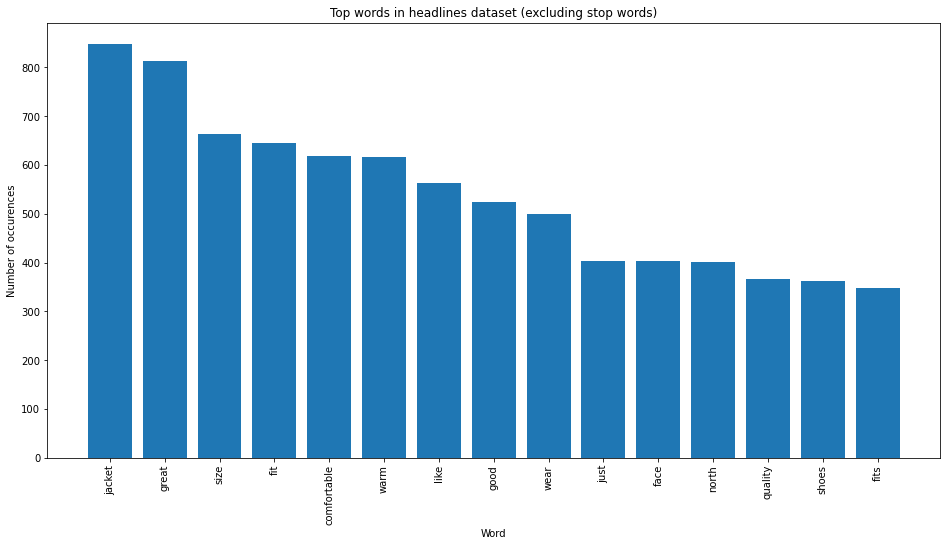

In [113]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_df)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

A histogram of headline word lengths is then generated and use part-of-speech tagging to understand the types of words used across the corpus.

In [114]:
tagged = [TextBlob(reindexed_df[i]).pos_tags for i in range(reindexed_df.shape[0])]


In [115]:
tagged_df = pd.DataFrame({'tags':tagged})

word_counts = [] 
pos_counts = {}

for headline in tagged_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  117513
Mean number of words per headline:  31.898208469055376


In [116]:
print(word_counts)

[45, 26, 7, 7, 163, 3, 46, 16, 17, 33, 45, 26, 7, 163, 3, 46, 16, 17, 33, 18, 40, 28, 218, 86, 10, 85, 12, 44, 148, 159, 54, 2, 61, 130, 34, 87, 10, 43, 7, 15, 117, 33, 20, 135, 84, 2, 122, 57, 55, 2, 82, 17, 39, 3, 25, 4, 35, 79, 43, 55, 89, 8, 46, 9, 49, 71, 46, 85, 4, 23, 28, 42, 183, 65, 73, 2, 9, 23, 6, 56, 83, 41, 4, 43, 49, 64, 32, 35, 51, 33, 48, 72, 12, 43, 70, 15, 2, 46, 9, 56, 19, 19, 75, 47, 58, 83, 47, 6, 8, 39, 48, 32, 45, 13, 8, 35, 8, 38, 7, 34, 45, 122, 7, 26, 32, 12, 121, 30, 10, 47, 49, 53, 9, 43, 18, 10, 26, 42, 1, 82, 30, 12, 1, 14, 47, 39, 28, 9, 14, 9, 16, 41, 81, 2, 40, 9, 13, 6, 41, 31, 26, 78, 24, 19, 11, 2, 7, 20, 26, 31, 65, 2, 24, 21, 38, 13, 35, 17, 5, 22, 28, 2, 24, 4, 25, 18, 15, 32, 24, 16, 17, 13, 19, 24, 50, 52, 1, 12, 26, 20, 16, 19, 10, 11, 9, 22, 69, 36, 22, 10, 21, 112, 15, 10, 13, 8, 12, 13, 17, 10, 7, 13, 8, 3, 9, 31, 9, 10, 26, 11, 10, 6, 14, 11, 24, 4, 22, 15, 18, 18, 35, 16, 5, 22, 4, 2, 13, 9, 11, 8, 20, 7, 5, 10, 10, 3, 8, 6, 99, 10, 2, 43,

In [117]:
word_counts

[45,
 26,
 7,
 7,
 163,
 3,
 46,
 16,
 17,
 33,
 45,
 26,
 7,
 163,
 3,
 46,
 16,
 17,
 33,
 18,
 40,
 28,
 218,
 86,
 10,
 85,
 12,
 44,
 148,
 159,
 54,
 2,
 61,
 130,
 34,
 87,
 10,
 43,
 7,
 15,
 117,
 33,
 20,
 135,
 84,
 2,
 122,
 57,
 55,
 2,
 82,
 17,
 39,
 3,
 25,
 4,
 35,
 79,
 43,
 55,
 89,
 8,
 46,
 9,
 49,
 71,
 46,
 85,
 4,
 23,
 28,
 42,
 183,
 65,
 73,
 2,
 9,
 23,
 6,
 56,
 83,
 41,
 4,
 43,
 49,
 64,
 32,
 35,
 51,
 33,
 48,
 72,
 12,
 43,
 70,
 15,
 2,
 46,
 9,
 56,
 19,
 19,
 75,
 47,
 58,
 83,
 47,
 6,
 8,
 39,
 48,
 32,
 45,
 13,
 8,
 35,
 8,
 38,
 7,
 34,
 45,
 122,
 7,
 26,
 32,
 12,
 121,
 30,
 10,
 47,
 49,
 53,
 9,
 43,
 18,
 10,
 26,
 42,
 1,
 82,
 30,
 12,
 1,
 14,
 47,
 39,
 28,
 9,
 14,
 9,
 16,
 41,
 81,
 2,
 40,
 9,
 13,
 6,
 41,
 31,
 26,
 78,
 24,
 19,
 11,
 2,
 7,
 20,
 26,
 31,
 65,
 2,
 24,
 21,
 38,
 13,
 35,
 17,
 5,
 22,
 28,
 2,
 24,
 4,
 25,
 18,
 15,
 32,
 24,
 16,
 17,
 13,
 19,
 24,
 50,
 52,
 1,
 12,
 26,
 20,
 16,
 19,
 10,
 11,
 9,
 22,


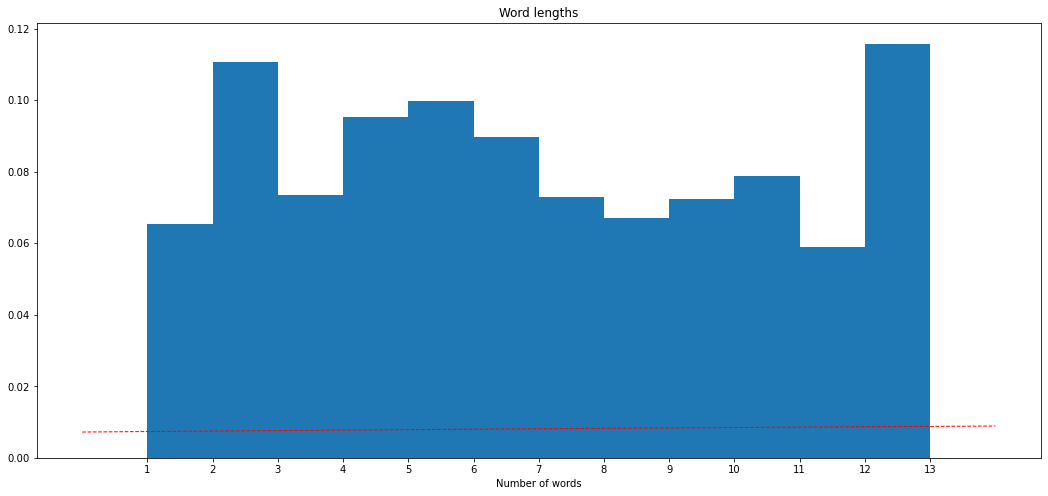

In [39]:
# y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

# fig, ax = plt.subplots(figsize=(18,8))
# ax.hist(word_counts, bins=range(1,14), density=True);

# ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
# ax.set_title('Word lengths');
# ax.set_xticks(range(1,14));
# ax.set_xlabel('Number of words');
# plt.show()

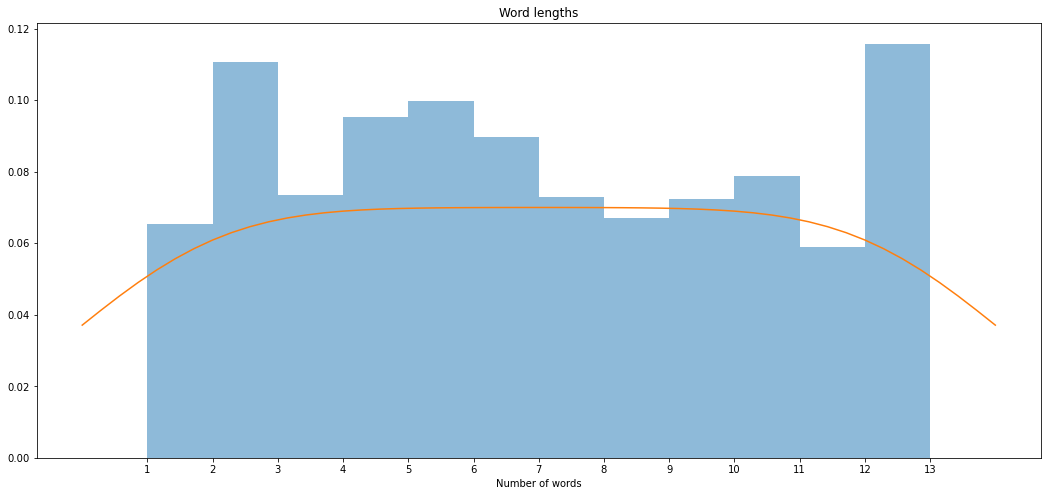

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
np.random.seed(41)

# word_counts = [45, 26, 7, 7, 163, 3, 46, 16, 17, 33, 45, 26, 7, 163, 3, 46, 16, 17, 33, 18, 40, 28, 218, 86, 10, 85, 12, 44, 148, 159, 54, 2, 61, 130, 34, 87, 10, 43, 7, 15, 117, 33, 20, 135, 84, 2, 122, 57, 55, 2, 82, 17, 39, 3, 25, 4, 35, 79, 43, 55, 89, 8, 46, 9, 49, 71, 46, 85, 4, 23, 28, 42, 183, 65, 73, 2, 9, 23, 6, 56, 83, 41, 4, 43, 49, 64, 32, 35, 51, 33, 48, 72, 12, 43, 70, 15, 2, 46, 9, 56, 19, 19, 75, 47, 58, 83, 47, 6, 8, 39, 48, 32, 45, 13, 8, 35, 8, 38, 7, 34, 45, 122, 7, 26, 32, 12, 121, 30, 10, 47, 49, 53, 9, 43, 18, 10, 26, 42, 1, 82, 30, 12, 1, 14, 47, 39, 28, 9, 14, 9, 16, 41, 81, 2, 40, 9, 13, 6, 41, 31, 26, 78, 24, 19, 11, 2, 7, 20, 26, 31, 65, 2, 24, 21, 38, 13, 35, 17, 5, 22, 28, 2, 24, 4, 25, 18, 15, 32, 24, 16, 17, 13, 19, 24, 50, 52, 1, 12, 26, 20, 16, 19, 10, 11, 9, 22, 69, 36, 22, 10, 21, 112, 15, 10, 13, 8, 12, 13, 17, 10, 7, 13, 8, 3, 9, 31, 9, 10, 26, 11, 10, 6, 14, 11, 24, 4, 22, 15, 18, 18, 35, 16, 5, 22, 4, 2, 13, 9, 11, 8, 20, 7, 5, 10, 10, 3, 8, 6, 99, 10, 2, 43, 4, 4, 2, 8, 18, 34, 1, 1, 4, 6, 2, 6, 9, 3, 5, 3, 2, 11, 5, 5, 7, 13, 16, 11, 41, 4, 2, 29, 10, 26, 7, 6, 1, 2, 6, 63, 10, 12, 29, 4, 6, 3, 2, 19, 6, 1, 21, 2, 5, 7, 7, 9, 8, 5, 1, 42, 21, 3, 13, 26, 3, 6, 21, 24, 7, 2, 3, 16, 6, 10, 13, 4, 1, 7, 2, 65, 6, 14, 2, 5, 1, 4, 1, 5, 2, 22, 102, 202, 135, 119, 141, 27, 15, 8, 60, 15, 61, 101, 38, 33, 43, 31, 38, 18, 175, 87, 58, 2, 5, 8, 9, 27, 20, 4, 62, 9, 2, 33, 26, 7, 33, 33, 13, 9, 32, 60, 14, 9, 4, 7, 8, 40, 26, 19, 31, 160, 35, 121, 89, 7, 31, 77, 13, 57, 64, 22, 30, 15, 5, 10, 28, 20, 23, 39, 7, 10, 74, 33, 26, 54, 33, 30, 42, 32, 53, 11, 2, 34, 13, 40, 5, 2, 32, 73, 17, 15, 17, 38, 39, 16, 36, 27, 29, 21, 6, 24, 9, 46, 5, 27, 22, 4, 1, 31, 2, 2, 6, 26, 31, 11, 6, 21, 10, 2, 15, 4, 26, 22, 21, 20, 20, 2, 20, 2, 2, 21, 45, 26, 7, 7, 163, 3, 46, 16, 17, 33, 45, 26, 7, 7, 163, 3, 46, 16, 17, 33, 18, 40, 28, 218, 86, 10, 85, 12, 44, 148, 159, 54, 2, 61, 130, 34, 87, 10, 43, 7, 15, 117, 33, 20, 135, 84, 2, 122, 57, 55, 2, 82, 17, 39, 3, 25, 4, 35, 79, 43, 55, 89, 8, 46, 9, 49, 71, 46, 85, 4, 23, 28, 42, 183, 65, 73, 2, 9, 23, 6, 56, 83, 41, 4, 43, 49, 64, 32, 35, 51, 33, 48, 72, 12, 43, 70, 15, 2, 46, 9, 56, 19, 7, 25, 46, 1, 67, 2, 44, 4, 7, 25, 46, 1, 67, 2, 44, 4, 7, 25, 46, 1, 5, 305, 1, 21, 21, 134, 39, 162, 50, 10, 5, 305, 21, 21, 134, 39, 162, 50, 10, 90, 58, 7, 12, 36, 113, 241, 63, 75, 122, 61, 91, 85, 81, 76, 12, 73, 47, 12, 57, 37, 36, 54, 78, 39, 47, 46, 23, 57, 34, 14, 44, 32, 24, 36, 11, 52, 21, 31, 43, 10, 34, 9, 86, 10, 43, 38, 39, 23, 15, 14, 23, 4, 11, 30, 35, 16, 27, 12, 9, 30, 5, 31, 29, 24, 3, 17, 13, 25, 90, 3, 29, 6, 26, 7, 16, 2, 26, 2, 20, 4, 25, 63, 4, 11, 19, 5, 25, 4, 12, 16, 21, 6, 3, 29, 9, 5, 15, 24, 22, 5, 14, 18, 12, 11, 40, 21, 22, 21, 10, 95, 16, 7, 19, 20, 14, 3, 19, 18, 14, 4, 13, 2, 67, 10, 13, 4, 16, 12, 8, 12, 12, 12, 15, 8, 6, 5, 9, 6, 3, 3, 12, 2, 8, 3, 11, 3, 6, 8, 11, 11, 2, 6, 7, 9, 9, 2, 12, 5, 9, 4, 4, 9, 8, 5, 4, 4, 30, 7, 2, 1, 6, 3, 4, 4, 1, 5, 5, 2, 2, 2, 3, 3, 5, 5, 2, 3, 1, 2, 2, 5, 5, 5, 5, 2, 2, 5, 4, 3, 2, 24, 3, 2, 32, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 10, 5, 10, 1, 213, 134, 17, 25, 220, 28, 32, 35, 10, 2, 1, 5, 305, 1, 21, 21, 134, 39, 162, 50, 10, 5, 305, 1, 21, 21, 134, 39, 162, 50, 10, 90, 58, 7, 12, 36, 113, 241, 63, 75, 122, 61, 91, 85, 81, 76, 12, 73, 47, 12, 57, 37, 36, 54, 78, 39, 47, 46, 23, 57, 34, 14, 29, 77, 16, 2, 24, 9, 13, 9, 1, 29, 77, 2, 24, 9, 13, 9, 1, 29, 16, 2, 151, 26, 77, 81, 28, 73, 90, 5, 219, 5, 151, 26, 77, 81, 28, 73, 90, 5, 219, 5, 11, 6, 22, 85, 4, 1, 1, 27, 6, 7, 12, 55, 15, 3, 2, 14, 8, 143, 49, 15, 5, 37, 6, 9, 8, 19, 10, 5, 29, 6, 40, 18, 1, 26, 7, 16, 27, 55, 3, 9, 43, 27, 14, 7, 2, 6, 5, 42, 15, 21, 3, 11, 30, 17, 21, 8, 5, 39, 59, 14, 9, 11, 23, 6, 26, 4, 7, 70, 38, 14, 42, 11, 3, 22, 45, 10, 1, 87, 68, 52, 140, 6, 29, 7, 3, 9, 5, 6, 30, 8, 151, 26, 77, 81, 28, 73, 90, 5, 219, 5, 151, 26, 77, 81, 28, 73, 90, 5, 219, 5, 11, 6, 22, 85, 4, 1, 1, 27, 6, 7, 1, 2, 14, 95, 44, 2, 3, 20, 32, 96, 5, 7, 3, 95, 44, 2, 3, 20, 32, 96, 5, 7, 3, 95, 44, 2, 3, 44, 36, 19, 15, 40, 52, 21, 61, 34, 10, 8, 19, 15, 52, 21, 61, 34, 10, 8, 69, 74, 1, 77, 12, 8, 4, 7, 2, 35, 19, 4, 19, 15, 40, 52, 61, 34, 10, 1, 34, 9, 45, 5, 17, 15, 75, 10, 20, 1, 34, 9, 45, 5, 17, 15, 75, 10, 20, 86, 1, 34, 9, 45, 5, 17, 15, 75, 10, 20, 22, 48, 100, 9, 22, 48, 100, 9, 22, 48, 84, 30, 19, 14, 34, 5, 2, 6, 17, 2, 84, 30, 14, 34, 5, 2, 6, 17, 2, 8, 6, 5, 4, 5, 3, 2, 30, 23, 6, 12, 6, 223, 2, 6, 8, 67, 7, 13, 10, 84, 30, 19, 14, 34, 5, 2, 6, 9, 17, 14, 18, 15, 6, 4, 6, 32, 11, 9, 17, 15, 6, 4, 6, 32, 11, 13, 22, 4, 186, 8, 1, 5, 13, 90, 10, 3, 9, 17, 14, 18, 15, 6, 4, 6, 32, 4, 42, 2, 29, 1, 4, 6, 33, 6, 93, 16, 8, 7, 13, 82, 88, 49, 15, 11, 14, 3, 8, 7, 13, 82, 88, 49, 15, 11, 14, 3, 2, 11, 11, 8, 7, 13, 82, 88, 49, 15, 11, 15, 2, 99, 49, 22, 33, 9, 10, 22, 19, 15, 2, 49, 22, 33, 9, 10, 22, 19, 29, 42, 30, 20, 209, 36, 4, 16, 10, 9, 8, 21, 3, 6, 6, 1, 14, 13, 49, 3, 16, 9, 12, 33, 32, 10, 13, 18, 51, 61, 11, 15, 2, 99, 49, 22, 33, 9, 10, 22, 19, 15, 2, 11, 7, 5, 64, 4, 32, 19, 10, 5, 8, 11, 7, 5, 64, 4, 32, 19, 10, 5, 8, 9, 8, 11, 8, 1, 4, 6, 11, 4, 29, 197, 17, 8, 17, 10, 12, 6, 9, 18, 3, 15, 5, 9, 9, 4, 2, 5, 14, 6, 5, 38, 27, 15, 18, 9, 4, 13, 74, 10, 7, 2, 40, 1, 52, 11, 7, 5, 64, 4, 32, 19, 10, 5, 8, 11, 7, 5, 64, 4, 32, 19, 21, 65, 17, 34, 79, 1, 21, 65, 17, 34, 79, 1, 21, 65, 17, 34, 79, 1, 21, 65, 38, 7, 11, 4, 6, 16, 21, 8, 4, 5, 38, 7, 4, 6, 16, 21, 8, 4, 5, 38, 7, 11, 4, 13, 73, 11, 5, 33, 25, 21, 17, 6, 4, 73, 11, 5, 33, 25, 21, 17, 6, 4, 73, 11, 5, 33, 10, 10, 10, 5, 5, 5, 130, 14, 24, 20, 25, 25, 12, 9, 130, 14, 24, 20, 25, 25, 12, 9, 130, 14, 24, 20, 12, 46, 5, 45, 67, 4, 12, 46, 45, 67, 4, 12, 46, 5, 45, 1, 27, 18, 16, 30, 13, 15, 40, 6, 18, 1, 27, 16, 30, 13, 15, 40, 6, 18, 36, 32, 30, 13, 2, 3, 19, 26, 45, 106, 5, 42, 46, 4, 13, 17, 6, 3, 4, 27, 12, 5, 51, 4, 13, 17, 6, 3, 4, 27, 12, 5, 51, 28, 2, 36, 2, 36, 3, 9, 15, 4, 13, 17, 6, 3, 4, 27, 11, 24, 3, 3, 2, 20, 60, 18, 16, 33, 28, 24, 3, 2, 20, 60, 18, 16, 33, 28, 54, 12, 17, 14, 10, 13, 6, 4, 31, 2, 47, 15, 24, 7, 13, 13, 21, 60, 23, 11, 18, 4, 24, 3, 3, 2, 20, 60, 18, 16, 33, 28, 24, 10, 10, 13, 29, 8, 43, 28, 50, 4, 2, 13, 10, 13, 29, 8, 43, 28, 50, 4, 2, 13, 9, 27, 6, 10, 13, 29, 8, 43, 28, 50, 4, 23, 38, 71, 37, 34, 6, 52, 59, 5, 13, 3, 3, 22, 28, 5, 293, 35, 135, 45, 16, 99, 22, 11, 12, 18, 293, 35, 135, 45, 16, 99, 22, 11, 12, 18, 8, 98, 5, 92, 6, 12, 8, 24, 48, 62, 7, 11, 65, 192, 72, 10, 103, 27, 45, 1, 5, 6, 5, 10, 34, 4, 95, 43, 20, 138, 6, 16, 59, 67, 17, 15, 2, 160, 53, 24, 25, 12, 77, 20, 17, 54, 12, 36, 18, 3, 47, 31, 3, 2, 8, 3, 1, 33, 20, 39, 20, 7, 6, 3, 45, 43, 1, 39, 28, 2, 3, 27, 25, 37, 6, 8, 34, 18, 23, 62, 26, 52, 139, 125, 49, 65, 68, 61, 13, 182, 61, 22, 5, 19, 61, 42, 23, 11, 42, 2, 78, 22, 14, 8, 6, 293, 35, 135, 45, 16, 99, 22, 11, 12, 18, 293, 35, 135, 45, 16, 99, 22, 11, 12, 18, 8, 98, 5, 92, 6, 12, 8, 24, 48, 62, 7, 11, 65, 192, 72, 10, 103, 27, 320, 53, 27, 14, 109, 206, 17, 11, 70, 53, 320, 14, 109, 206, 17, 11, 70, 53, 49, 132, 80, 40, 65, 8, 2, 77, 89, 103, 78, 40, 6, 10, 85, 54, 88, 81, 98, 126, 9, 25, 66, 31, 49, 26, 5, 3, 3, 73, 53, 191, 10, 46, 14, 7, 36, 41, 18, 20, 28, 60, 45, 51, 24, 8, 15, 49, 154, 24, 23, 12, 71, 24, 33, 14, 7, 63, 54, 2, 30, 59, 13, 36, 73, 2, 5, 20, 17, 6, 19, 6, 146, 6, 14, 25, 21, 19, 2, 157, 2, 5, 66, 4, 33, 4, 77, 7, 12, 17, 50, 19, 69, 42, 45, 54, 20, 12, 92, 116, 32, 144, 68, 15, 115, 56, 132, 72, 55, 63, 27, 297, 18, 87, 78, 67, 12, 74, 51, 67, 60, 56, 48, 17, 174, 26, 42, 63, 33, 102, 83, 19, 33, 35, 5, 9, 32, 70, 30, 55, 4, 55, 6, 54, 29, 15, 19, 39, 15, 18, 18, 11, 15, 11, 73, 7, 32, 37, 6, 9, 3, 29, 18, 38, 27, 63, 15, 30, 61, 36, 13, 26, 117, 6, 54, 35, 72, 48, 4, 22, 13, 23, 69, 19, 52, 1, 20, 22, 21, 39, 2, 20, 19, 15, 43, 27, 13, 18, 9, 89, 15, 16, 19, 15, 18, 13, 38, 41, 40, 8, 15, 33, 6, 127, 34, 4, 7, 13, 15, 6, 29, 34, 12, 4, 5, 28, 10, 26, 23, 26, 6, 7, 7, 7, 1, 1, 20, 1, 21, 24, 21, 7, 22, 1, 4, 29, 2, 3, 19, 2, 17, 1, 15, 16, 15, 3, 15, 12, 21, 72, 11, 1, 11, 21, 10, 18, 48, 17, 18, 9, 6, 7, 9, 9, 25, 7, 5, 7, 7, 5, 4, 4, 4, 4, 86, 4, 5, 1, 37, 2, 2, 2, 2, 2, 1, 9, 60, 55, 91, 84, 31, 344, 31, 4, 68, 20, 6, 22, 29, 2, 16, 15, 8, 3, 2, 1, 5, 3, 128, 103, 47, 74, 44, 109, 64, 49, 29, 10, 43, 8, 21, 36, 21, 34, 99, 38, 2, 2, 74, 2, 58, 62, 19, 25, 5, 18, 11, 90, 11, 6, 55, 21, 6, 4, 4, 11, 22, 30, 78, 41, 13, 2, 9, 4, 44, 196, 70, 2, 4, 36, 26, 120, 7, 9, 3, 29, 16, 76, 55, 15, 6, 7, 3, 100, 7, 87, 19, 149, 30, 139, 34, 46, 43, 25, 51, 95, 9, 33, 68, 80, 80, 21, 10, 16, 64, 67, 49, 78, 13, 32, 70, 2, 35, 74, 44, 58, 22, 60, 30, 17, 53, 55, 33, 6, 46, 15, 46, 51, 5, 44, 19, 1, 41, 14, 7, 39, 37, 5, 37, 37, 18, 11, 8, 12, 11, 16, 17, 32, 30, 41, 32, 28, 27, 24, 14, 10, 18, 24, 27, 27, 17, 22, 17, 2, 3, 19, 12, 14, 6, 13, 6, 4, 14, 12, 24, 4, 3, 4, 13, 11, 13, 12, 1, 4, 12, 14, 7, 5, 10, 8, 7, 5, 6, 4, 6, 7, 6, 2, 4, 7, 4, 3, 2, 3, 55, 4, 1, 2, 10, 3, 1, 10, 8, 1, 5, 3, 6, 1, 6, 3, 25, 4, 4, 8, 320, 53, 27, 14, 109, 206, 17, 11, 70, 53, 320, 53, 27, 14, 109, 206, 17, 11, 70, 53, 49, 132, 80, 40, 65, 8, 2, 77, 89, 103, 78, 40, 6, 10, 85, 54, 88, 81, 98, 126, 9, 25, 66, 31, 49, 26, 5, 3, 3, 73, 53, 191, 10, 46, 14, 7, 36, 41, 18, 20, 28, 60, 45, 51, 24, 8, 15, 49, 154, 24, 23, 12, 71, 24, 33, 14, 7, 63, 54, 2, 30, 59, 13, 36, 73, 2, 5, 20, 17, 6, 19, 6, 146, 6, 14, 25, 21, 19, 2, 157, 2, 5, 66, 4, 33, 4, 77, 7, 12, 17, 50, 19, 69, 42, 45, 54, 20, 12, 92, 116, 32, 144, 68, 15, 115, 56, 132, 72, 55, 63, 27, 297, 18, 87, 78, 67, 12, 74, 51, 67, 60, 56, 48, 17, 174, 26, 42, 63, 3, 5, 4, 74, 18, 6, 79, 10, 9, 32, 3, 5, 74, 18, 6, 79, 10, 9, 32, 55, 16, 3, 7, 6, 28, 173, 23, 6, 4, 27, 23, 11, 19, 26, 37, 57, 8, 22, 3, 11, 12, 14, 27, 9, 24, 10, 7, 3, 5, 4, 74, 18, 6, 79, 10, 9, 32, 3, 5, 4, 74, 18, 6, 79, 10, 7, 16, 14, 8, 51, 7, 6, 1, 24, 8, 7, 16, 8, 51, 7, 6, 1, 24, 8, 25, 4, 53, 13, 6, 10, 2, 15, 17, 2, 74, 8, 17, 8, 20, 29, 15, 7, 16, 14, 8, 51, 7, 6, 1, 24, 8, 7, 45, 58, 27, 135, 10, 22, 21, 38, 174, 41, 45, 58, 135, 10, 22, 21, 38, 174, 41, 13, 192, 63, 59, 65, 14, 9, 17, 64, 11, 78, 40, 45, 31, 39, 11, 2, 14, 2, 25, 22, 24, 9, 19, 22, 9, 15, 12, 52, 11, 2, 5, 39, 24, 24, 40, 2, 37, 10, 51, 45, 5, 24, 22, 7, 7, 26, 45, 58, 27, 135, 10, 22, 21, 38, 174, 41, 45, 58, 27, 135, 10, 22, 21, 38, 33, 14, 25, 81, 48, 15, 12, 9, 4, 5, 33, 81, 48, 15, 12, 9, 4, 5, 13, 7, 62, 50, 19, 11, 1, 32, 15, 78, 89, 99, 55, 26, 251, 95, 80, 68, 12, 5, 1, 2, 31, 107, 53, 23, 34, 24, 34, 16, 11, 32, 9, 21, 16, 8, 6, 10, 2, 5, 11, 2, 52, 4, 13, 21, 13, 9, 76, 33, 72, 26, 27, 33, 14, 25, 81, 48, 15, 12, 9, 4, 5, 33, 14, 25, 81, 48, 15, 12, 9, 4, 5, 13, 7, 62, 50, 19, 3, 26, 2, 44, 19, 105, 45, 41, 4, 5, 3, 26, 2, 44, 19, 105, 45, 41, 4, 5, 138, 11, 3, 26, 2, 44, 19, 105, 45, 41, 35, 124, 40, 41, 25, 9, 5, 42, 32, 10, 35, 124, 40, 41, 25, 9, 5, 42, 32, 10, 7, 38, 6, 242, 77, 10, 184, 79, 3, 23, 36, 12, 14, 3, 2, 145, 164, 90, 6, 51, 62, 20, 67, 8, 26, 24, 18, 1, 28, 24, 78, 97, 1, 73, 39, 6, 10, 7, 11, 6, 7, 40, 3, 4, 74, 4, 2, 8, 41, 5, 36, 33, 2, 14, 52, 8, 7, 12, 36, 25, 56, 4, 46, 10, 40, 1, 7, 157, 22, 24, 42, 16, 18, 52, 26, 7, 8, 15, 8, 15, 12, 9, 43, 6, 5, 4, 4, 6, 16, 13, 39, 159, 57, 18, 9, 11, 2, 11, 8, 110, 7, 59, 29, 81, 81, 14, 10, 6, 1, 49, 5, 83, 18, 6, 35, 124, 40, 41, 25, 9, 5, 42, 32, 10, 35, 124, 40, 41, 25, 9, 5, 42, 32, 10, 7, 38, 6, 242, 77, 10, 184, 79, 3, 23, 36, 12, 14, 3, 2, 145, 164, 14, 7, 55, 2, 174, 67, 11, 8, 17, 205, 14, 2, 174, 67, 11, 8, 17, 205, 166, 28, 110, 15, 14, 103, 38, 18, 30, 3, 17, 12, 66, 21, 8, 1, 9, 24, 3, 41, 5, 16, 4, 41, 16, 19, 21, 19, 110, 16, 8, 17, 17, 12, 59, 5, 11, 15, 8, 7, 8, 2, 10, 10, 37, 1, 2, 4, 5, 3, 15, 2, 13, 6, 89, 3, 19, 22, 61, 23, 23, 4, 10, 9, 16, 19, 49, 76, 87, 8, 24, 3, 73, 1, 35, 26, 12, 17, 3, 9, 4, 4, 5, 3, 14, 2, 19, 9, 14, 7, 55, 2, 174, 67, 11, 8, 17, 205, 14, 7, 55, 2, 174, 67, 11, 8, 17, 205, 166, 28, 110, 15, 14, 103, 38, 8, 2, 5, 29, 41, 8, 51, 9, 5, 29, 41, 8, 51, 9, 5, 29, 25, 3, 8, 23, 33, 12, 1, 73, 13, 25, 3, 8, 23, 33, 12, 1, 73, 13, 1, 17, 16, 49, 11, 12, 10, 3, 43, 10, 105, 13, 17, 29, 18, 28, 54, 12, 42, 31, 17, 12, 11, 5, 11, 33, 29, 11, 12, 19, 6, 11, 6, 441, 23, 8, 66, 6, 3, 14, 7, 16, 20, 1, 103, 37, 20, 19, 13, 35, 6, 39, 25, 3, 8, 23, 33, 12, 1, 73, 13, 25, 3, 8, 23, 33, 12, 1, 73, 13, 1, 41, 2, 45, 2, 54, 14, 9, 12, 2, 41, 2, 45, 2, 54, 14, 9, 12, 2, 2, 41, 10, 44, 18, 54, 12, 14, 4, 5, 5, 10, 10, 54, 12, 14, 4, 5, 5, 10, 45, 12, 69, 40, 24, 11, 5, 45, 13, 28, 15, 27, 4, 41, 4, 6, 25, 8, 14, 5, 2, 3, 8, 9, 9, 2, 7, 6, 6, 1, 1, 1, 13, 2, 10, 6, 3, 7, 15, 10, 7, 5, 1, 22, 7, 6, 14, 4, 12, 71, 13, 56, 7, 36, 13, 4, 1, 12, 11, 2, 11, 14, 6, 3, 4, 4, 16, 33, 5, 1, 1, 5, 10, 44, 18, 54, 12, 14, 4, 5, 5, 10, 10, 44, 18, 54, 12, 14, 4, 5, 10, 45, 12, 69, 40, 46, 14, 31, 143, 95, 12, 9, 79, 42, 46, 14, 31, 143, 95, 12, 9, 79, 42, 15, 44, 13, 36, 48, 3, 5, 28, 5, 20, 1, 4, 4, 1, 11, 4, 15, 16, 2, 18, 2, 5, 68, 4, 6, 4, 6, 12, 91, 9, 12, 32, 20, 9, 16, 127, 14, 6, 4, 14, 41, 9, 33, 15, 2, 32, 1, 8, 9, 7, 6, 6, 46, 14, 31, 143, 95, 12, 9, 79, 42, 46, 14, 31, 143, 95, 12, 9, 79, 42, 15, 72, 42, 10, 6, 18, 15, 34, 32, 8, 32, 72, 42, 6, 18, 15, 34, 32, 8, 32, 100, 9, 91, 72, 45, 9, 39, 12, 117, 21, 8, 28, 42, 14, 125, 23, 72, 42, 10, 6, 18, 15, 34, 32, 8, 32, 72, 42, 27, 20, 190, 44, 50, 70, 10, 8, 47, 25, 27, 20, 190, 44, 50, 70, 10, 8, 47, 25, 27, 20, 190, 44, 13, 5, 29, 27, 4, 12, 10, 3, 10, 40, 13, 5, 27, 4, 12, 10, 3, 10, 40, 25, 33, 4, 28, 50, 2, 60, 23, 49, 5, 1, 8, 9, 18, 18, 3, 4, 9, 1, 5, 13, 5, 29, 27, 4, 12, 10, 3, 17, 9, 1, 16, 11, 34, 33, 93, 30, 44, 10, 42, 90, 16, 11, 34, 33, 93, 30, 44, 10, 42, 90, 38, 54, 34, 26, 16, 11, 34, 33, 93, 30, 44, 10, 76, 78, 33, 76, 78, 33, 83, 68, 19, 2, 83, 68, 19, 2, 83, 68, 45]  # Your data goes here

y = stats.norm.pdf(np.linspace(0, 14, 50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18, 8))
ax.hist(word_counts, bins=range(1, 14), density=True, alpha=0.5)
kde = stats.gaussian_kde(np.linspace(0, 14, 50))
xx = np.linspace(0, 14, 50)
ax.plot(xx, kde(xx))
                                      
# ax.plot(np.linspace(0, 14, 50), y, 'r--', linewidth=1)

ax.set_title('Word lengths')
ax.set_xticks(range(1, 14))
ax.set_xlabel('Number of words')
plt.show()

- A combined histogram is generated and KDE plot to provide insights into the distribution of word counts. The histogram represents the observed frequencies or densities of word counts, while the KDE estimates the underlying continuous distribution.


In [119]:
word_counts

[45,
 26,
 7,
 7,
 163,
 3,
 46,
 16,
 17,
 33,
 45,
 26,
 7,
 163,
 3,
 46,
 16,
 17,
 33,
 18,
 40,
 28,
 218,
 86,
 10,
 85,
 12,
 44,
 148,
 159,
 54,
 2,
 61,
 130,
 34,
 87,
 10,
 43,
 7,
 15,
 117,
 33,
 20,
 135,
 84,
 2,
 122,
 57,
 55,
 2,
 82,
 17,
 39,
 3,
 25,
 4,
 35,
 79,
 43,
 55,
 89,
 8,
 46,
 9,
 49,
 71,
 46,
 85,
 4,
 23,
 28,
 42,
 183,
 65,
 73,
 2,
 9,
 23,
 6,
 56,
 83,
 41,
 4,
 43,
 49,
 64,
 32,
 35,
 51,
 33,
 48,
 72,
 12,
 43,
 70,
 15,
 2,
 46,
 9,
 56,
 19,
 19,
 75,
 47,
 58,
 83,
 47,
 6,
 8,
 39,
 48,
 32,
 45,
 13,
 8,
 35,
 8,
 38,
 7,
 34,
 45,
 122,
 7,
 26,
 32,
 12,
 121,
 30,
 10,
 47,
 49,
 53,
 9,
 43,
 18,
 10,
 26,
 42,
 1,
 82,
 30,
 12,
 1,
 14,
 47,
 39,
 28,
 9,
 14,
 9,
 16,
 41,
 81,
 2,
 40,
 9,
 13,
 6,
 41,
 31,
 26,
 78,
 24,
 19,
 11,
 2,
 7,
 20,
 26,
 31,
 65,
 2,
 24,
 21,
 38,
 13,
 35,
 17,
 5,
 22,
 28,
 2,
 24,
 4,
 25,
 18,
 15,
 32,
 24,
 16,
 17,
 13,
 19,
 24,
 50,
 52,
 1,
 12,
 26,
 20,
 16,
 19,
 10,
 11,
 9,
 22,


In [120]:
np.mean(word_counts)

31.898208469055376

In [121]:
np.std(word_counts)

40.804121577656645

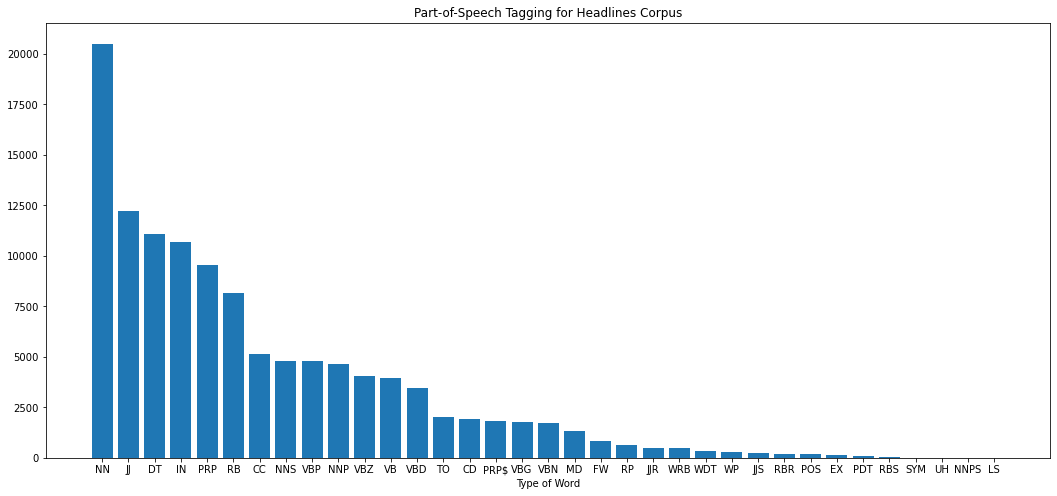

In [122]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');

- A bar plot is generated where each bar represents the frequency or count of different part-of-speech tags in a corpus of headlines. The x-axis shows the types of words (part-of-speech tags), and the height of each bar represents the count of that particular tag. This plot provides a visual representation of the distribution of part-of-speech tags in the headlines corpus.


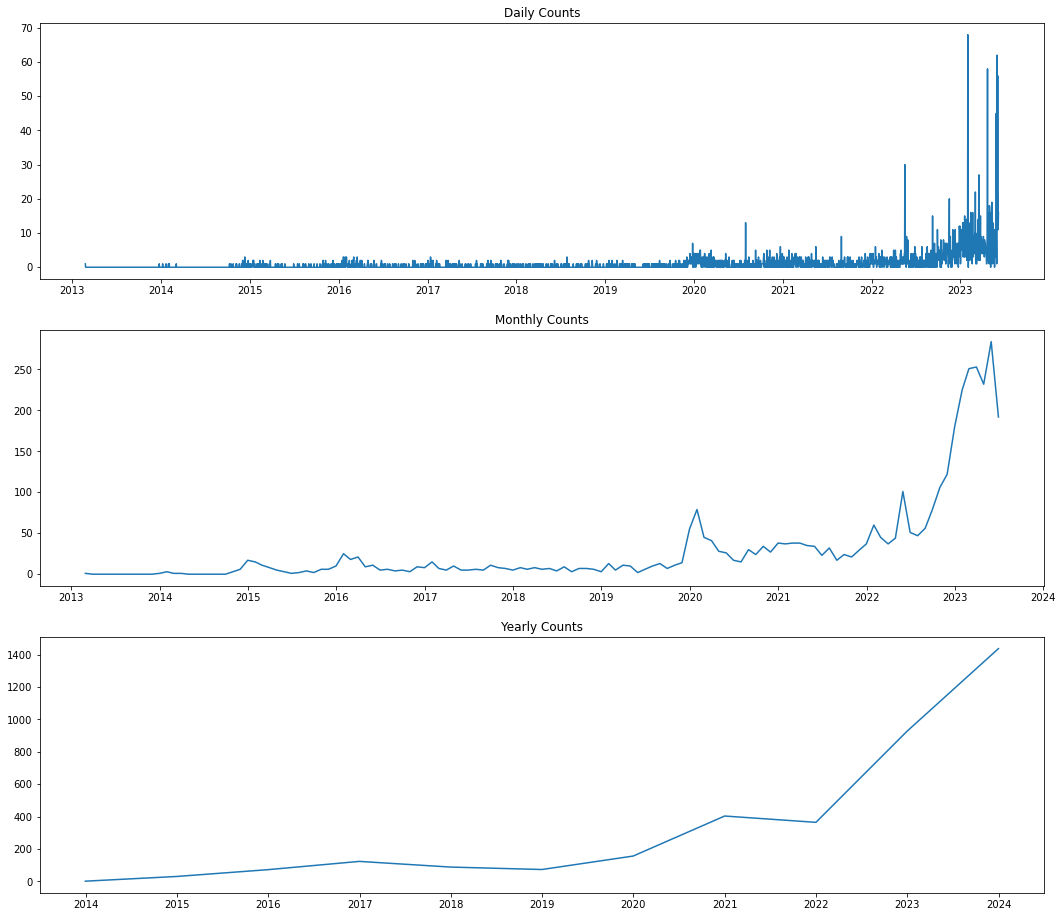

In [48]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# monthly_counts = reindexed_df.resample('M').count()
# yearly_counts = reindexed_df.resample('A').count()
# daily_counts = reindexed_df.resample('D').count()

# fig, ax = plt.subplots(3, figsize=(18, 16))

# ax[0].plot(daily_counts)
# ax[0].set_title('Daily Counts')

# ax[1].plot(monthly_counts)
# ax[1].set_title('Monthly Counts')

# ax[2].plot(yearly_counts)
# ax[2].set_title('Yearly Counts')

# # Adjust x-axis tick labels for each subplot
# for axes in ax:
#     axes.xaxis.set_major_locator(mdates.YearLocator())
#     axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# plt.show()


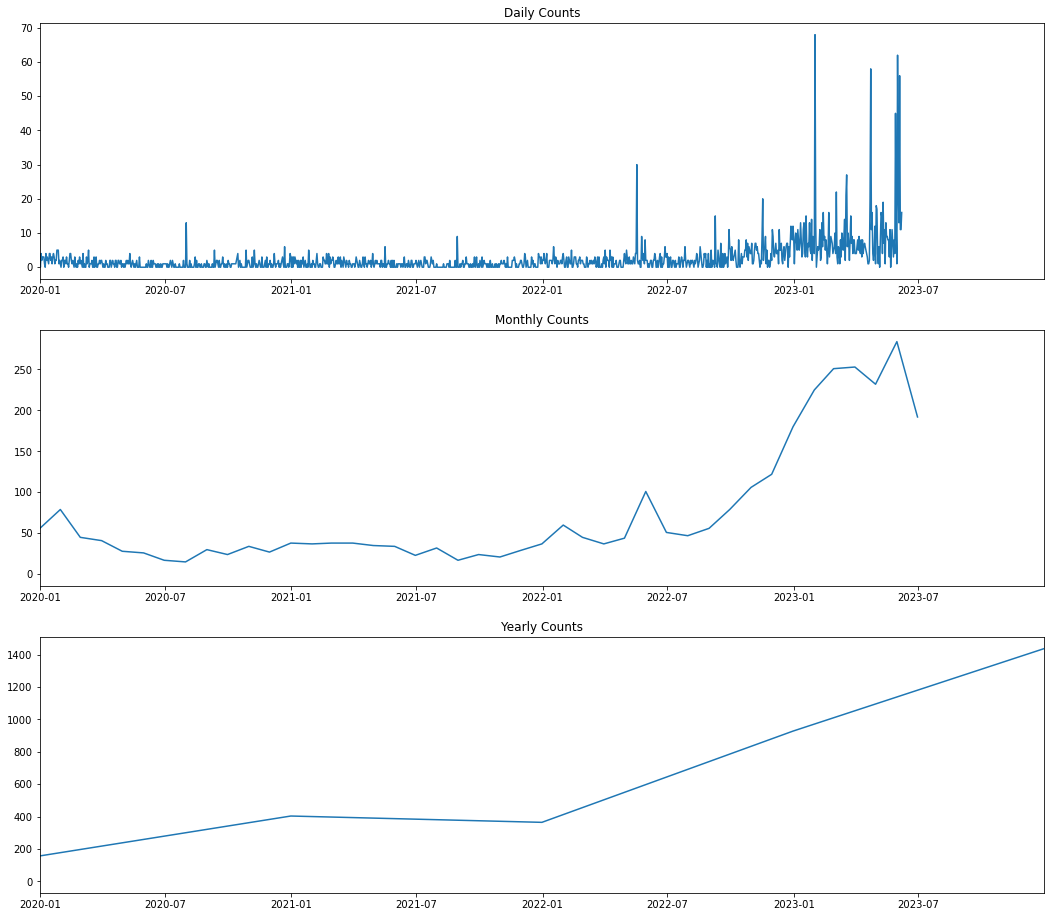

In [123]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

monthly_counts = reindexed_df.resample('M').count()
yearly_counts = reindexed_df.resample('A').count()
daily_counts = reindexed_df.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18, 16))

ax[0].plot(daily_counts)
ax[0].set_title('Daily Counts')
ax[0].set_xlim(datetime(2020, 1, 1), datetime(2023, 12, 31))

ax[1].plot(monthly_counts)
ax[1].set_title('Monthly Counts')
ax[1].set_xlim(datetime(2020, 1, 1), datetime(2023, 12, 31))

ax[2].plot(yearly_counts)
ax[2].set_title('Yearly Counts')
ax[2].set_xlim(datetime(2020, 1, 1), datetime(2023, 12, 31))

plt.show()


- Above graphs produce three line plots representing the counts of a variable over different time intervals: daily, monthly, and yearly. It provides a visual representation of how the counts vary over time at different levels of granularity.


## Topic Modelling

Clustering algorithm was applied to the corpus in order to study the topic focus, as well as how it has evolved through time. 

#### Preprocessing

To convert each string to a numerical vector using CountVectorizer.

In [124]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_df.sample(n=1000, random_state=0).values

print('Before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('After vectorization: \n{}'.format(small_document_term_matrix[123]))

Before vectorization: Love this hat. Great quality.
After vectorization: 
  (0, 1324)	1
  (0, 1386)	1
  (0, 2331)	1
  (0, 1751)	1


In [125]:
n_topics = 8

### Latent Semantic Analysis

In [126]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [127]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [128]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [129]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word)
#             topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [130]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])
    

Topic 1:  jacket great comfortable warm fit size good like wear just
Topic 2:  shoes shoe pair comfortable purchased cold size weather wore durable
Topic 3:  hat north face head great like quality super die high
Topic 4:  la son el que es en muy si para il
Topic 5:  size small grey color tnf hat large dark black fits
Topic 6:  logo tnf did like choice beanie liked just don lining
Topic 7:  venture original rain release hood jackets spring charging resolve adjustable
Topic 8:  north face shoe bought jacket mountain hardwear wear ultra weather


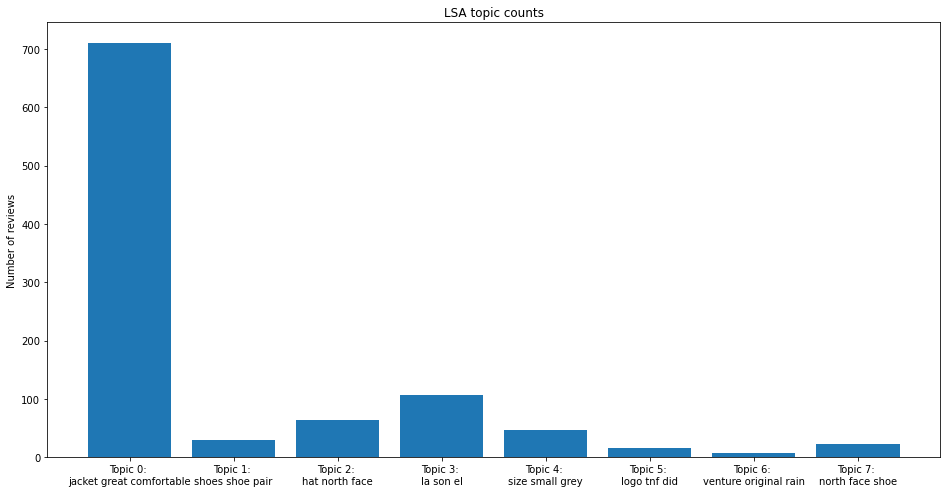

In [144]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of reviews');
ax.set_title('LSA topic counts');
plt.show()

- A bar chart showing the topic counts for the LSA topics is generated, with each bar labeled by the topic index and its corresponding top 3 words. The height of each bar represents the number of headlines associated with that topic.


𝑡-SNE (t-Distributed Stochastic Neighbor Embedding) is used for dimensionality reduction for visualizing high-dimensional data in a lower-dimensional space(typically 2D or 3D).

In [132]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

C:\Users\peini\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.007s...
[t-SNE] Computed neighbors for 1000 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.086366
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.463985
[t-SNE] KL divergence after 2000 iterations: 0.471753


In [133]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [134]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [135]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

Based on the above graph, it is a bit of a failed result as there is no great degree of separation across the topic categories.

(I) A scatter plot is generated using t-SNE clustering for the LSA topics. Each data point represents a headline, and its position in the plot is determined by the t-SNE vectors. The color of each data point corresponds to its associated LSA topic. Additionally, labels are added to the plot, displaying the top 3 words for each LSA topic at the mean coordinates of the topic in the t-SNE space.

(II) From here, we could observe that the data for ‘jacket  great comfortable’ has a spread out data points thus do not exhibit a clear pattern or trend.

(III) Since the data points are scattered randomly without any discernible pattern, it suggests that there is no significant relationship between the variables.


## Latent Dirichilet Allocation (LDA)

In [136]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

arg max of each entry in the topic matrix is used to obtain the predicted topic category.

In [137]:
import numpy as np

arr = np.array([17, 12, 25, 10, 5])

index = np.argmax(arr)

print(index)


2


In [138]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [139]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  size fit warm comfortable like wear great jacket small good
Topic 2:  la il non di logo molto si sono prodotto tessuto
Topic 3:  jacket great fit warm hat comfortable good like north face
Topic 4:  comfortable jacket love great feet face north wear warm loves
Topic 5:  la el es en que muy son para se calidad
Topic 6:  die sie und jacke sich der ich hält ein das
Topic 7:  expected face north exactly hardwear mountain cómodas est bought le
Topic 8:  super shirt caldo ich comfortable soft ma il 30 stretto


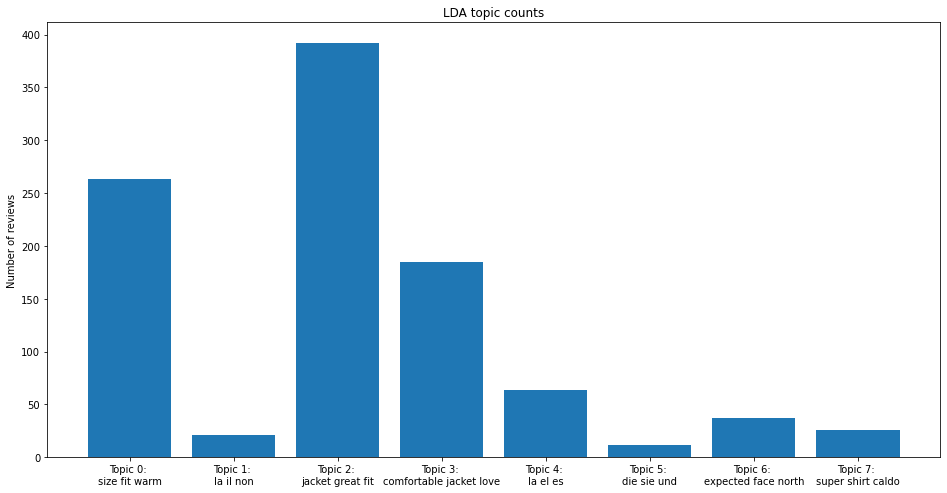

In [143]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of reviews');

- Topic 2, 0 and 3 are ranked first, second and third in terms of the number of reviews as per LDA topic counts respectively, this results corresponds to the scatter plot obtained, which depicts that distinct linear line pattern of datapoints are observed. 


To compare LSA and LDA

In [141]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

C:\Users\peini\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.031546
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.341469
[t-SNE] KL divergence after 1600 iterations: 0.198695


In [142]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

(I) Focused or clustered data points are observed, it exhibits a distinct pattern or concentration while indicating a stronger correlation or relationship between the more structured variables.

(II) It forms a tight cluster or follows a distinct trend. The values of one variable provide useful information about the values of the other variable, the clustered data points forms a linear line pattern.

(III) This is a much better result. It would seem that LDA is more effective than LSA in separating out the topic categories.

### Scaling Up

In [65]:
# big_sample_size = 3685

# big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
# big_text_sample = reindexed_df.sample(n=big_sample_size, random_state=0).values
# big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

# big_lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online')
# big_lda_model.fit(big_document_term_matrix);

In [66]:
# Define the value of big_sample_size
big_sample_size = 1000

# Read the Excel file
reindexed_df = pd.read_excel('excel_file.xlsx')

# Sample the DataFrame
sampled_df = reindexed_df.sample(n=big_sample_size, replace=True, random_state=0)

# Extract the 'text' column as a Series
text_series = sampled_df['contents']

# Convert the Series to lowercase
text_series = text_series.str.lower()

# Fill missing values with an empty string
text_series = text_series.fillna('')

# Convert the Series to a NumPy array
big_text_sample = text_series.values

# Create CountVectorizer
big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)

# Fit and transform the text sample
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

# Create LDA model
n_topics = 10
big_lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online')

# Fit the LDA model
big_lda_model.fit(big_document_term_matrix)

LatentDirichletAllocation(learning_method='online')

In [70]:
big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
big_document_term_matrix = big_count_vectorizer.fit_transform(reindexed_df.values)

big_lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online')
big_lda_model.fit(big_document_term_matrix)


LatentDirichletAllocation(learning_method='online', n_components=8)

In [71]:
yearly_data = []
for i in range(2020,2022+1):
    yearly_data.append(reindexed_df['{}'.format(i)].values)

yearly_topic_matrices = []
for year in yearly_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    yearly_topic_matrices.append(topic_matrix)

yearly_keys = []
for topic_matrix in yearly_topic_matrices:
    yearly_keys.append(get_keys(topic_matrix))
    
yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)

yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(2020,2022+1))
yearly_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]

print(yearly_topic_counts)

      Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  Topic 8
2020       16       26      254       18       15       34       23       18
2021       22       20      231       14       31       13       14       20
2022      598       46       52       98       40       23       20       51


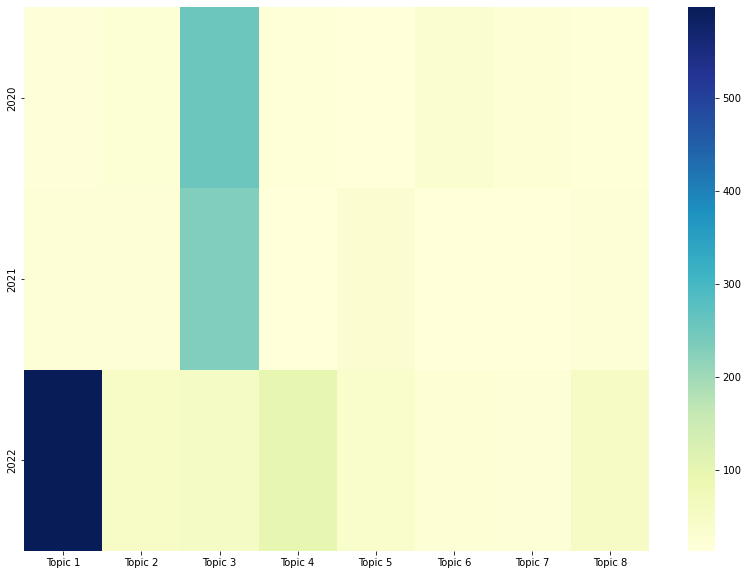

In [72]:
fig, ax = plt.subplots(figsize=(14,10))
sb.heatmap(yearly_topic_counts, cmap="YlGnBu", ax=ax);
plt.show()

The evolution across time are shown using a heatmap. It shows that Topic 1 is the most popular topic.

### Evaluation Metrics

- For LSA, cosine similarity metric is used to evaluate the performance of the model

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

# Read the Excel file
df = pd.read_excel('excel_file.xlsx')

# Extract the column containing the text documents
documents = df['contents'].astype(str).tolist()

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on your preprocessed text documents
X = vectorizer.fit_transform(documents)

In [76]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Apply TruncatedSVD for dimensionality reduction
lsa_model = TruncatedSVD(n_components=10)
lsa_matrix = lsa_model.fit_transform(X)

# Compute cosine similarity
similarity_matrix = cosine_similarity(lsa_matrix)
mean_similarity = similarity_matrix.mean()
print("Mean Cosine Similarity:", mean_similarity)

Mean Cosine Similarity: 0.33433140354372787


- For LDA, perplexity and coherence score for LDA is obtained via Gensim

In [77]:
import gensim
from gensim.utils import simple_preprocess

# Read the Excel file
df = pd.read_excel('excel_file.xlsx')

# Retrieve the column containing the string data from your DataFrame
documents = df['contents'].tolist()

# Preprocess the documents, converting float values to strings
preprocessed_docs = [simple_preprocess(str(doc)) for doc in documents]

# Create a dictionary from the preprocessed documents
dictionary = gensim.corpora.Dictionary(preprocessed_docs)

# Create the corpus
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

In [78]:
import gensim
from gensim.models import LdaModel, CoherenceModel

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

# Compute perplexity
perplexity = lda_model.log_perplexity(corpus)
print("Perplexity:", perplexity)

# Compute coherence
coherence_model = CoherenceModel(model=lda_model, texts=preprocessed_docs, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print("Coherence Score:", coherence_score)

Perplexity: -7.0130244085139
Coherence Score: 0.5165183261215247
